# Experiments for slicing images

After several failures with simple convolutional layers, mostly because shallow (and small) CNN can't properly detect small features on such big images, I wanted to try a bit "bigger" models.
But more robust models couldn't fit data batches in the RAM (even for a single image, since we need to preserve a lot of its filtered versions in CNN).

To address this problem, we are going to cut images in pieces and work with them.

If we split images into small ones during the preprocessing step, this will reduce memory load, and allow us to build deeper models. But after this, our first preprocessing goal of extracting the original image (plain text) from the generated one (noisy), becomes unreasonable. Because now the cut part of an image may not contain the text that we want to preserve.

Since I was satisfied with the results that can be achieved with OpenCV library, we can drop the idea (for now) of preprocessing images using deep learning and move to the second step - text detection.

Note (to do). Slicing produces many "empty" images. So I'm interested in one more preprocessing step, that can improve performance. Classification of an image - whether it contains text, or not. Basic idea - if an image doesn't contain any text, why bother with any attempts to locate it. 

# Imports

In [1]:
import cv2
import matplotlib.pyplot as plt

import numpy as np
import os
import pickle

import tensorflow as tf
from tensorflow import keras

from google.colab.patches import cv2_imshow

### Utility functions (some of them discussed later and duplicated here for convenience)

In [2]:
# Display images
def plot_gray_images(images, labels=None, n_cols=5, figsize=(32,48)):
  """
  Takes list of images and plots them in "tiled" fashion.
  """
  plt.figure(figsize=figsize)
  n = len(images)
  n_rows = n // n_cols + 1
  for i, image in enumerate(images):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(image, cmap="gray") # if shape (x,y, 1) .squeeze()
    plt.axis('off')
    if labels:
      plt.title(labels[i])

def recover_image(sliced_images, image_size, n_images):
  """
  Recove image from tf.image.extract_patches. 
  sliced_images - tf.constant with shape - [n_images, height, width, 1]
  image_size - tuple (height,width) original image size (before slicing)
  n_images - tuple (horizontal, vertical) number of patches 
  """
  # Drop single color channel
  sliced_images = tf.squeeze(sliced_images)
  kernel_size = sliced_images.shape[1:3]
  steps = [(image_size[i] - kernel_size[i]) // (n_images[i] - 1) for i in range(2)]
  # Initialize image
  recovered = tf.zeros(image_size)
  mask = tf.zeros(image_size, dtype=tf.int8)
  # Kernel for counting overlaps
  kernel_ones = tf.ones(kernel_size,dtype=tf.int8)
  for j in range(n_images[0]):
    for i in range(n_images[1]):
      # Make indices from meshgrid
      indexes = tf.meshgrid(tf.range(steps[0] * j, # row start
                                    kernel_size[0] + steps[0] * j), # row end
                            tf.range(steps[1] * i, # col_start
                                    kernel_size[1] + steps[1] * i), indexing='ij') # col_end
      indexes = tf.stack(indexes, axis=-1)
      # Add sliced image to recovered image indice
      recovered = tf.tensor_scatter_nd_add(recovered, indexes, sliced_images[i+j*n_images[0]])
      # Update mask
      mask = tf.tensor_scatter_nd_add(mask, indexes, kernel_ones)

  recovered = recovered / tf.cast(mask, tf.float32)
  return recovered

# Functions to split and reconstruct image

If we would simply cut images whith scissors our edge parts would be unrecognizable. That is why I want to slide over images with a window (with given size and stride) and keep overlapping parts. 

At reconstruction stage we can simply average overlapping parts.

Example below

## Example

In [3]:
# Display images
def plot_gray_images(images, labels=None, n_cols=5, figsize=(32,48)):
  """
  Takes list of images and plots them in "tiled" fashion.
  """
  plt.figure(figsize=figsize)
  n = len(images)
  n_rows = n // n_cols + 1
  for i, image in enumerate(images):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(image, cmap="gray") # if shape (x,y, 1) .squeeze()
    plt.axis('off')
    if labels:
      plt.title(labels[i])

(229, 512, 1)


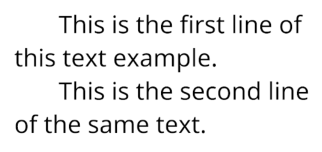

In [4]:
#loag image
#image_path = "/content/drive/My Drive/DocumentProcessing/Test_images/image_2.jpg"
image_path = "/content/drive/My Drive/DocumentProcessing/Test_images/test_text.png"


image = tf.io.read_file(image_path)
image = tf.image.decode_png(image, channels=1)
image = tf.image.convert_image_dtype(image, tf.float32)
print(image.shape)
plot_gray_images([image.numpy().squeeze()])

### Slicing image

Shape of resulted slices:  [1, 5, 5, 24840]
Reshaped to images:  [25, 115, 216]


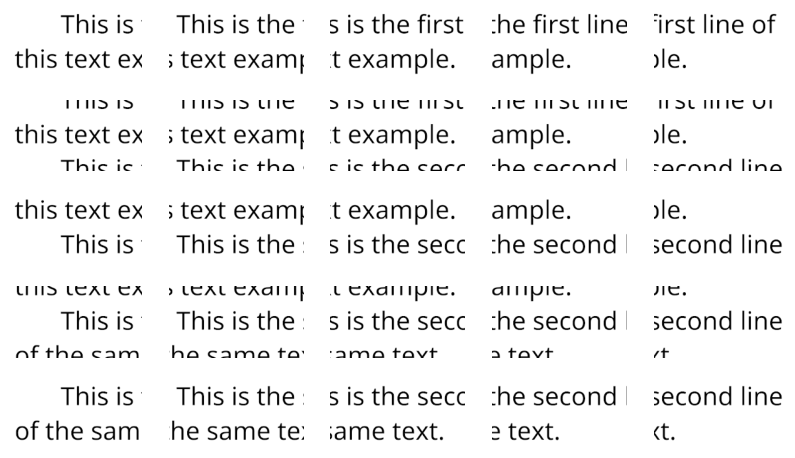

In [5]:
n_images_v = 5
n_images_h = 5
kernel_size = (115, 216)
steps = [(image.shape[i] - kernel_size[i]) // (n_images_v - 1) for i in range(2)]

# Making slices
slices = tf.image.extract_patches(tf.expand_dims(image, axis=0), # adding batch axis
              sizes=[1,kernel_size[0], kernel_size[1],1], 
              strides=[1, steps[0], steps[1], 1], 
              rates=[1,1,1,1], 
              padding="VALID")

print("Shape of resulted slices: ", slices.shape.as_list())
# Reshaping into images (later we would want to add color channel dimension)
sliced_images = tf.reshape(slices, (-1, kernel_size[0], kernel_size[1]))
print("Reshaped to images: ", sliced_images.shape.as_list())
plot_gray_images(sliced_images.numpy(), n_cols=n_images_h, figsize=(14,10))

### Recovering image

I found some topics on "reversing" tf.image.extract_patches, but there was no solution. So, let's crack this problem.

https://github.com/tensorflow/tensorflow/issues/6743

Idea 1: Since we want the mean of overlapping pixels, we can add all pixels to a proper location and divide by the number of additions (overlaps). 



*   Create 2 arrays of zeros of the same size as an original image (black image)
*   One array will be an image where we add our patches, second will be the "mask", that counts how many patches any pixel received.
*   Divide the image by the mask



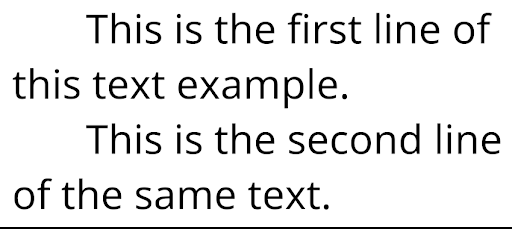

In [6]:
def recover_image(sliced_images, image_size, n_images):
  """
  Recove image from tf.image.extract_patches. 
  sliced_images - tf.constant with shape - [n_images, height, width, 1]
  image_size - tuple (height,width) original image size (before slicing)
  n_images - tuple (horizontal, vertical) number of patches 
  """
  # Drop single color channel
  sliced_images = tf.squeeze(sliced_images)
  kernel_size = sliced_images.shape[1:3]
  steps = [(image_size[i] - kernel_size[i]) // (n_images[i] - 1) for i in range(2)]
  # Initialize image
  recovered = tf.zeros(image_size)
  mask = tf.zeros(image_size, dtype=tf.int8)
  # Kernel for counting overlaps
  kernel_ones = tf.ones(kernel_size,dtype=tf.int8)
  for j in range(n_images[0]):
    for i in range(n_images[1]):
      # Make indices from meshgrid
      indexes = tf.meshgrid(tf.range(steps[0] * j, # row start
                                    kernel_size[0] + steps[0] * j), # row end
                            tf.range(steps[1] * i, # col_start
                                    kernel_size[1] + steps[1] * i), indexing='ij') # col_end
      indexes = tf.stack(indexes, axis=-1)
      # Add sliced image to recovered image indice
      recovered = tf.tensor_scatter_nd_add(recovered, indexes, sliced_images[i+j*n_images[0]])
      # Update mask
      mask = tf.tensor_scatter_nd_add(mask, indexes, kernel_ones)

  recovered = recovered / tf.cast(mask, tf.float32)
  return recovered


img = recover_image(tf.expand_dims(sliced_images, axis=-1), 
                    image_size=(229, 512), 
                    n_images=(5,5))
cv2_imshow(img.numpy()*255)

# Implementing data preprocessing pipeline (using tf.data) 
To ensure slicing will work within tensorflow graphs
### (Unfinished - switched to working with preprocessing for YoloV3)




Uploading from my drive

In [15]:
# Utility functions
GENERATED_IMAGE_SIZE = [2729, 1923]
IMAGE_SIZE = [2270, 1600]
RESIZE_COEFF = [IMAGE_SIZE[i] / GENERATED_IMAGE_SIZE[i] for i in range(2)]
BATCH_SIZE = 1
PREFETCH = 1

def process_image(image_path, resize=True, channels=1):
  """
  Takes image path and preprocess it and returns reshaped tensor
  """
  image = cv2.imread(image_path.numpy().decode("utf-8"))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  segmented = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,15)
  image = np.where(segmented == 255, segmented, image)

  image = tf.constant(np.expand_dims(image, axis = 2) / 255, tf.float32)
  # Resize image
  if resize:
    image = tf.image.resize(image, size=IMAGE_SIZE)
  return image



def cut_image(image, n_images=(8,8), kernel_size = (300, 210)):
  # Consider making parameter steps
  steps = [(IMAGE_SIZE[i] - kernel_size[i]) // (n_images[i] - 1) for i in range(2)]
  # Making slices
  slices = tf.image.extract_patches(tf.expand_dims(image, axis=0), # adding batch axis
                sizes=[1,kernel_size[0], kernel_size[1],1], 
                strides=[1, steps[0], steps[1], 1], 
                rates=[1,1,1,1], 
                padding="VALID")

  # Reshaping into images (later we would want to add color channel dimension)
  sliced_images = tf.reshape(slices, (-1, kernel_size[0], kernel_size[1], 1))
  return sliced_images

## Cut boxes (Unfinished)

In [16]:
def process_boxes(box_path, resize=True):
  with open(box_path.numpy().decode("utf-8"), "rb") as f:
    image_boxes = pickle.load(f)
    image_word_boxes = [] 
    # Save only boxes for words (not for characters)
    for boxes in image_boxes:
      image_word_boxes.append(boxes["box"])
    image_boxes = tf.constant(image_word_boxes, dtype=tf.float32)
    if resize:
      image_boxes = tf.math.round(image_boxes * RESIZE_COEFF)

    return image_boxes

In [20]:
# Turning data into batches
def create_data_batches(X, y, batch_size=BATCH_SIZE):
  """
  Takes filepathes and returns TF data object
  """
  data = tf.data.Dataset.from_tensor_slices((X, y))
  data = data.map(lambda X1, y1: (tf.py_function(process_image, inp=[X1], 
                                                 Tout=tf.float32), 
                                  y1)
                                  # Unfinished
                                  #tf.py_function(process_boxes, inp=[y1], 
                                 #                Tout=tf.float32)))
  
  # Cut an image and unbatch them
  
  data = data.map(lambda X1,y1: (cut_image(X1), y1)).unbatch()
                             
  data_batch = data.batch(BATCH_SIZE).prefetch(PREFETCH)
    
  return data_batch

In [18]:
# Get file pathes

data_path = "/content/drive/My Drive/DocumentProcessing/DDI_data/01/"
gen_data_path = data_path + "gen_imgs/"
# list of full filepathes to generated images
gen_img_pathes = [gen_data_path + img_name 
                  for img_name in os.listdir(gen_data_path) if ".png" in img_name]

boxes_filepathes = [(path[:-3] + "pickle").replace("gen_imgs", "gen_boxes")
                                               for path in gen_img_pathes]

NUM_IMAGES = len(gen_img_pathes)

#  Making splits

X, y = np.array(gen_img_pathes), np.array(boxes_filepathes)

train_split = int(NUM_IMAGES * 0.7)
test_split = train_split + (NUM_IMAGES - train_split) // 2
X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split: test_split], y[train_split: test_split]
X_test, y_test = X[test_split:], y[test_split:]
X_train.shape, X_valid.shape, X_test.shape

((1134,), (243,), (243,))

In [ ]:
# Creating datasets

IMAGE_SIZE = [2270, 1600]
BATCH_SIZE = 16
PREFETCH = 1

train_data = create_data_batches(X_train, y_train)
#valid_data = create_data_batches(X_valid, y_valid)
#test_data = create_data_batches(X_test, y_test)

whole_gen, whole_orig = [], []
for gen, orig in train_data.take(4):
  whole_gen.append(gen)
  whole_orig.append(orig)

whole_gen_image = tf.concat([*whole_gen],axis=0)
print("Batch shape", gen.shape.as_list())
print("Concatenated image shape", whole_gen_image.shape.as_list())

### Visualisation of the sliced and recovered image

Note. Had some troubles when printing whole white tiles (matplotlib displays them as black, but imshow handles it correctly)

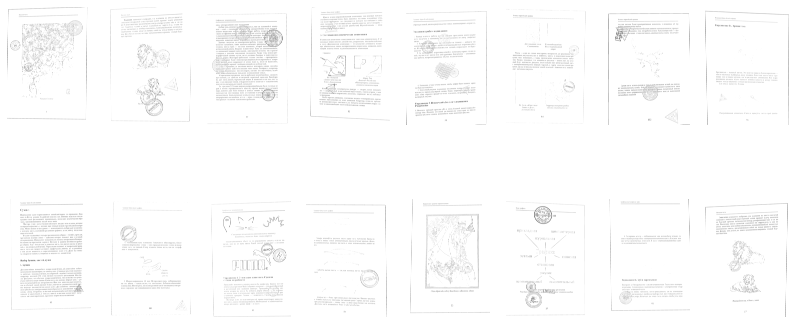

In [14]:
plot_gray_images(whole_gen_image[0:16].numpy().squeeze(), n_cols=8, figsize=(14,10))

In [ ]:
# Recovering whole image from 64 parts
img = recover_image(whole_gen_image, 
                    image_size=(2270, 1600), 
                    n_images=(8,8))
cv2_imshow(img.numpy()*255)

# Visualisation of the image with boxes


Loading pickle files with boxes arrays

In [22]:
# Take sample of 5 images
X_sample = X_train[0:5]

# Load boxes of this images
#label_pathes = [(X[:-3] + "pickle").replace("gen_imgs", "gen_boxes") for X in X_sample]
images_word_boxes = []
images = []
for path in X_sample:
  # Load image
  images.append(process_image(tf.constant(path)))
  # Load boxes
  label_path = (path[:-3] + "pickle").replace("gen_imgs", "gen_boxes")
  with open(label_path, "rb") as f:
    image_boxes = pickle.load(f)
    image_word_boxes = [] 
    # Save only boxes for words (not for characters)
    for boxes in image_boxes:
      image_word_boxes.append(boxes["box"])
    images_word_boxes.append(tf.constant(image_word_boxes))

  

#type(images_word_boxes[0]), type(images[0])
images[1].shape, images_word_boxes[1].shape

(TensorShape([2270, 1600, 1]), TensorShape([77, 4, 2]))

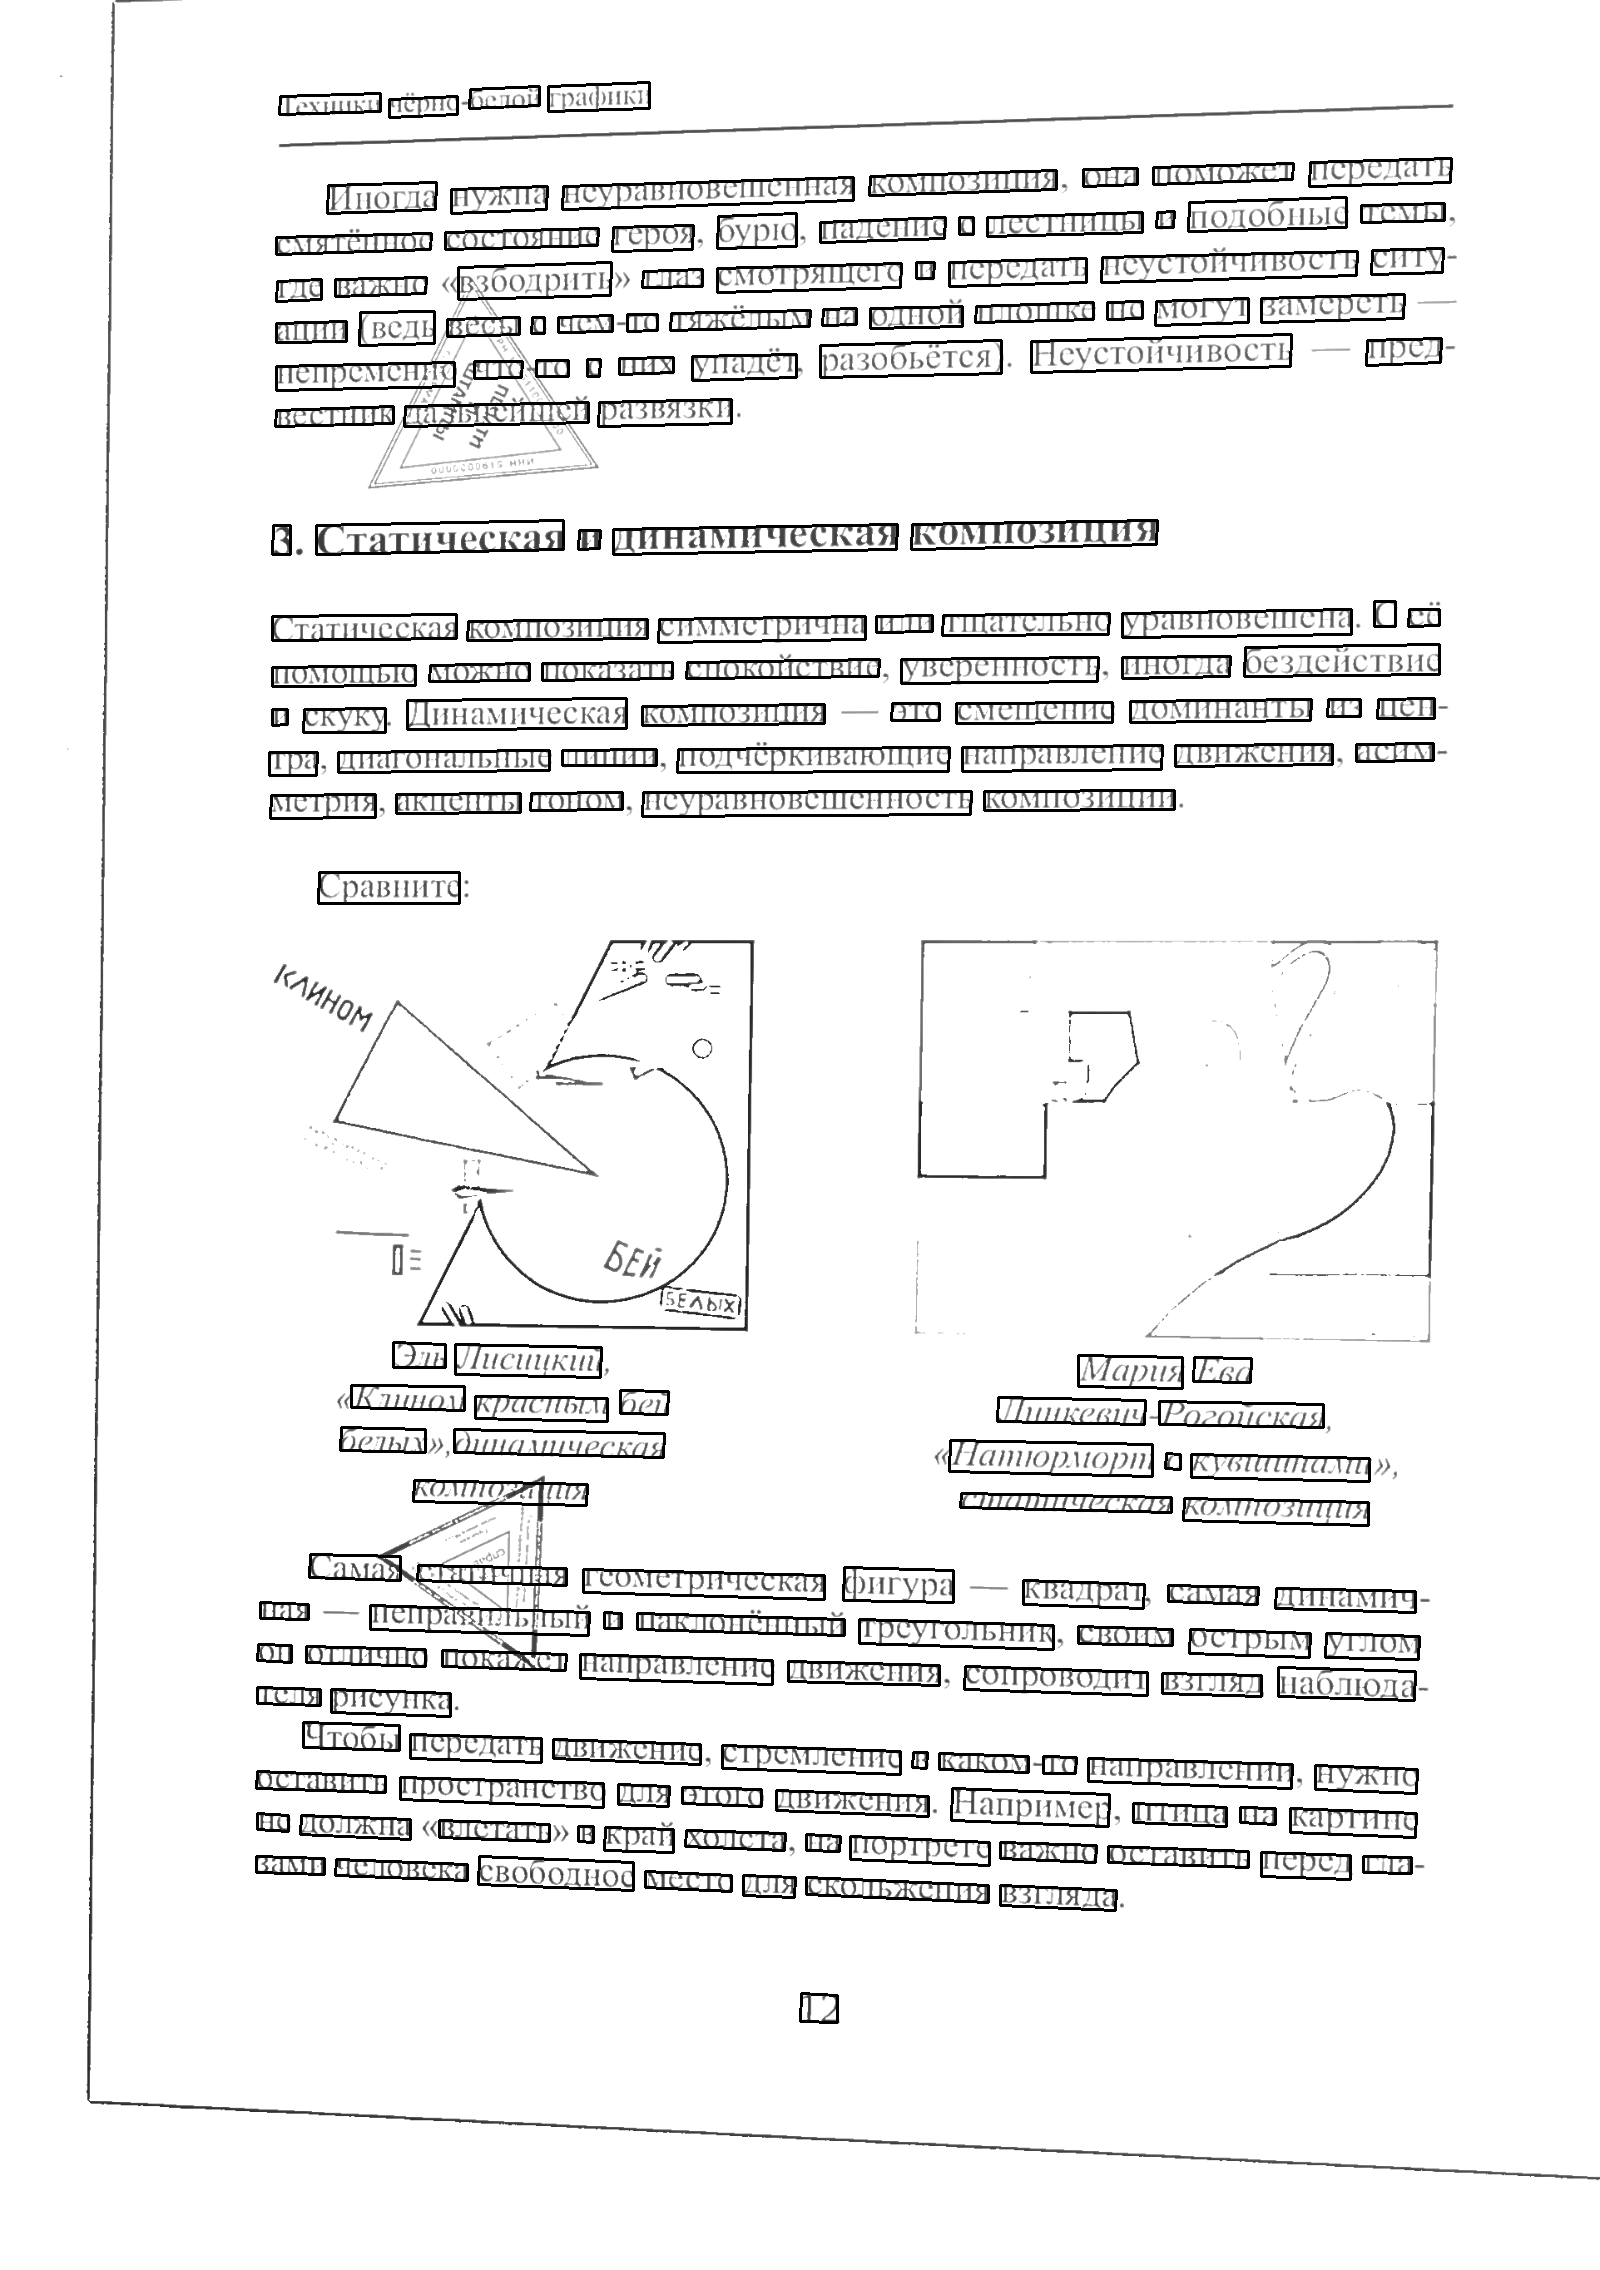

In [23]:
# Show image with boxes

image_n = 3

def box_resize_reshape(or_size=(2729, 1923), resized=(2270, 1600)):
  resize_coeff = [resized[i] / or_size[i] for i in range(2)]
  def resize_box(box):
    # Can be done much simpler (using broadcasting)
    box = box.numpy()[[0, 1, 3, 2], ::-1].reshape((-1, 1, 2))
    box[:, 0, 0] = box[:, 0, 0] * resize_coeff[0]
    box[:, 0, 1] = box[:, 0, 1] * resize_coeff[1]
    return box
  return resize_box

process_box = box_resize_reshape(or_size=(2729, 1923), resized=(2270, 1600))

boxes = [process_box(box) for box in images_word_boxes[image_n]]
box_image = cv2.polylines(images[image_n].numpy().squeeze() * 255, boxes, True, (0, 0, 0), 2) 

cv2_imshow(box_image)

In [ ]:
# or manually
# boxes = [box['box'][[0, 1, 3, 2], ::-1].reshape((-1, 1, 2)) for box in data]
# image = cv2.polylines(img, boxes, True, (0, 0, 0), 2) 

# Cutting boxes (to match the cut image)
Empty. Implemented during YOLOv3 data preprocessing.

Straitforward approach - keep a label if a single point of the box is present in the image, and clip to edges all points that are outside the image.

# Next notebook: YOLOv3 for text detection.